# Module 1： Body Fat Analysis
## group1: Lize Du, Xioahan Wang
----------------------------------------

## Abstract

Because our goal is to find a simple and robust model, so we need to focus on how to make the model easy to understand and simple to interpret, besides we also need to make sure that our prediction is accurate for most cases.

To reach our purpose, we think SLR model is good enough and easy to interpret. Inspired by the instructor, we think we can also make use of our orginal data and gain some prior information, then use Bayes rule to calculate. The specified steps will be clarified later.

To validate and choosing model, we use a 5-fold CV, because we need to do variable selection manualy so a loop doesn't help and the total data is only 252, so we choose to do a 5-fold CV.

We will also make some charts to help interpret our model, including model selection and model diagnosis part.

In the end, we also make a shiny app to help the user to easily calculate their body fat easily.

In [156]:
library(corrplot)
library(ggplot2)
library(dplyr)
library(gridExtra)
library(caret)
library(leaps)
library(MASS)
#load the package we need


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [115]:
setwd("~/Desktop/module1")

In [116]:
data<-read.csv("BodyFat.csv",header = T)
summary(data)

      IDNO           BODYFAT         DENSITY           AGE       
 Min.   :  1.00   Min.   : 0.00   Min.   :0.995   Min.   :22.00  
 1st Qu.: 63.75   1st Qu.:12.80   1st Qu.:1.041   1st Qu.:35.75  
 Median :126.50   Median :19.00   Median :1.055   Median :43.00  
 Mean   :126.50   Mean   :18.94   Mean   :1.056   Mean   :44.88  
 3rd Qu.:189.25   3rd Qu.:24.60   3rd Qu.:1.070   3rd Qu.:54.00  
 Max.   :252.00   Max.   :45.10   Max.   :1.109   Max.   :81.00  
     WEIGHT          HEIGHT        ADIPOSITY          NECK      
 Min.   :118.5   Min.   :29.50   Min.   :18.10   Min.   :31.10  
 1st Qu.:159.0   1st Qu.:68.25   1st Qu.:23.10   1st Qu.:36.40  
 Median :176.5   Median :70.00   Median :25.05   Median :38.00  
 Mean   :178.9   Mean   :70.15   Mean   :25.44   Mean   :37.99  
 3rd Qu.:197.0   3rd Qu.:72.25   3rd Qu.:27.32   3rd Qu.:39.42  
 Max.   :363.1   Max.   :77.75   Max.   :48.90   Max.   :51.20  
     CHEST           ABDOMEN            HIP            THIGH      
 Min.   : 79.30 

From above graph, we can see that fat and density is highly related, because we know that Adiposity can be calculated using height and weight, 

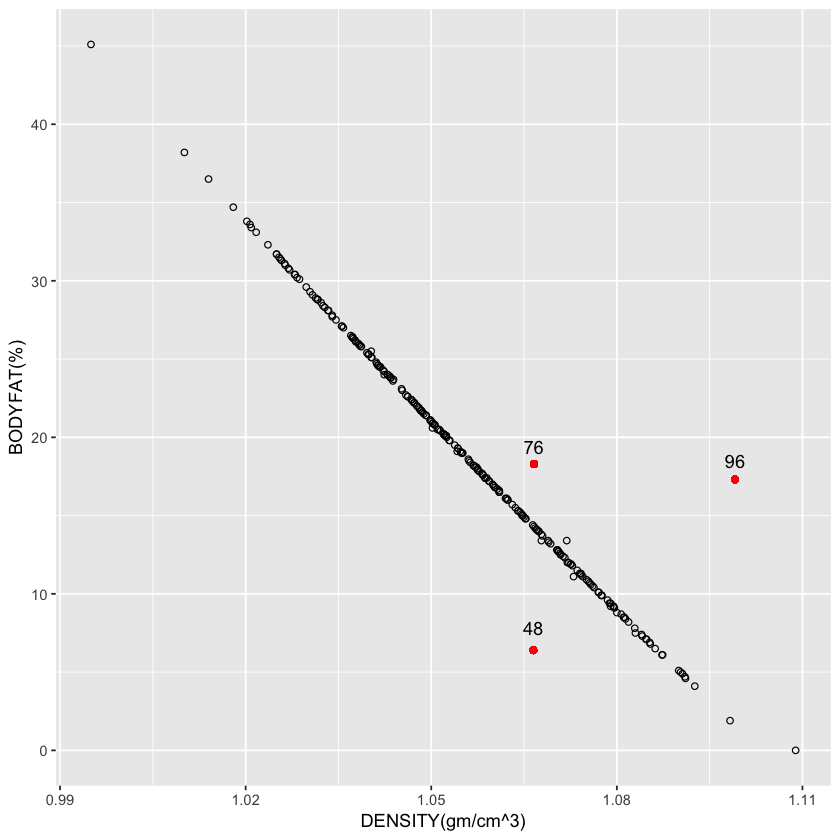

In [117]:
pic1<-ggplot(data,aes(x=DENSITY,y=BODYFAT))+geom_point(shape=21)+xlab("DENSITY(gm/cm^3)")+ylab("BODYFAT(%)")+ 
geom_point(aes(x=1.0991,y=17.3),colour="red")+
geom_point(aes(x=1.0665,y=6.4),colour="red")+ geom_point(aes(x=1.0666,y=18.3),colour="red")+ 
annotate("text",x=1.0991,y=18.5,label="96")+ annotate("text",x=1.0665,y=7.8,label="48")+ 
annotate("text",x=1.0666,y=19.4,label="76")
print(pic1)

We notice that there are 3 points don't lie on the line, and we know the relationship between them is BODYFAT = 495/DENSITY - 450 (1), and we use this equation to check the three outliers.

In [118]:
find_outlier<-function(a,b){
    dif<-((495/a-450)-b)^2
    return(order(dif,decreasing = T)[1:3])
}
find_outlier(data$DENSITY,data$BODYFAT)

[1] 96 48 76

In [119]:
data[c(96,48,76),]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
96,96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
48,48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
76,76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3


Using the equation (1), we can calculate the bodyfat percentage assuming density is correct, and we can see:

IDNO | BODYFAT | CAL_BODYFAT
---- | ------- | -----------
96 | 17.3 | 0.37
48 | 6.4 | 14.14
76 | 18.3 | 14.09

We can see the difference is giant, and because the Percent body fat is calculated from Siri's equation, i.e. equation(1), so we think we should trust CAL_BODYFAT, so I choose to use density as our response variable, and in the end, when we making prediction of one's percentage of fat, we will use Siri's equation to do that.

In [120]:
data<-data[,-(1:2)]#delete the index column and the bodyfat column, because we don't need them when building our model

## Data cleaning

42 
42

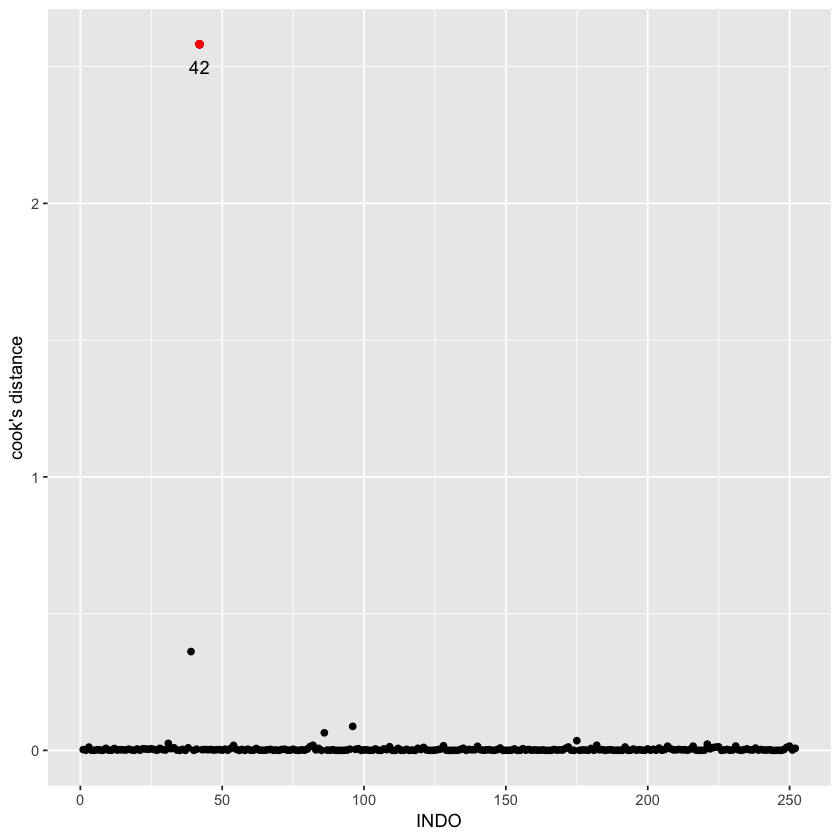

In [121]:
#firstly,we build a linear model to check if there is any outliers which need to be eliminated
m1<-lm(DENSITY~.,data)
which.max(cooks.distance(m1))#check the most influence point
d1<-data.frame(index=as.numeric(1:252),cooks=as.numeric(cooks.distance(m1)))
pic2<-ggplot(d1,aes(x=index,y=cooks))+geom_point()+annotate("text",x=42,y=2.5,label="42")+
geom_point(x=42,y=2.581225,colour="red")+
xlab("INDO")+ylab("cook's distance")
print(pic2)
#we find 42 is a high influence point

,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,1.025,44,205,29.5,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


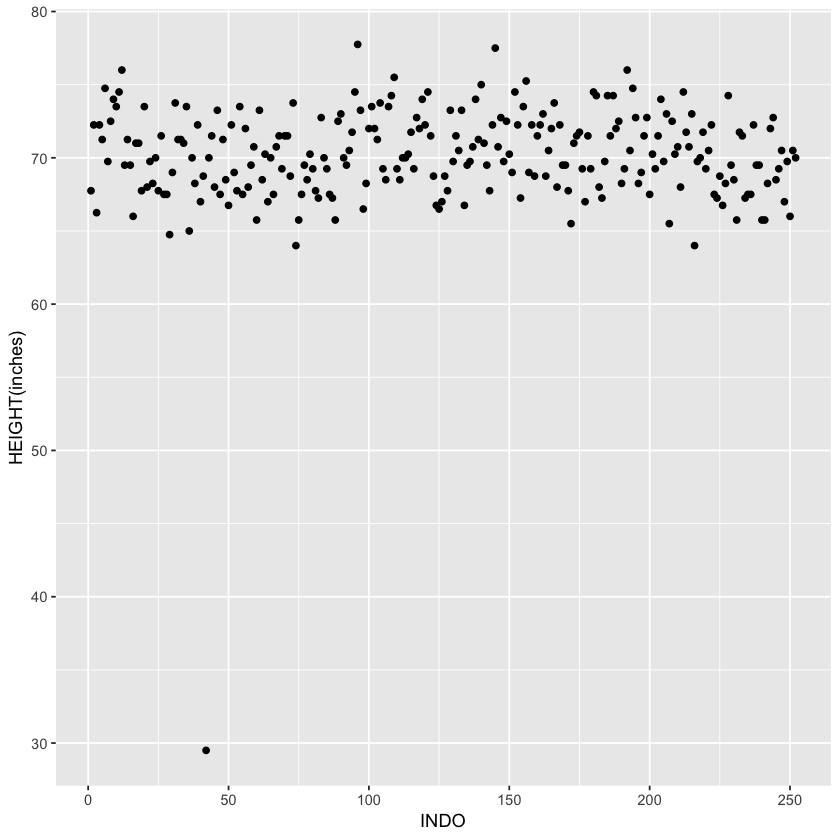

In [122]:
data[42,]#shortest guy
pic3<-ggplot(data,aes(x=1:252,y=HEIGHT))+geom_point()+xlab("INDO")+ylab("HEIGHT(inches)")#we think the error is made 
#because a typo from the plot because it seperates so far from others
print(pic3)

To determine if wer should retain this point or not, we use the BMI, and we search on google and know that  
*BMI(kg/m^2) = 0.45WEIGHT(lbs) / (0.025HEIGHT(inches))^2* (2)   
then we can calculate the height by assuming WEIGHT and ADIPOSITY is correct, and this man is 70.3 inched tall, so there must be something wrong among these three number, but we cannot decide which is wrong, so just delete it.

In [123]:
data<-data[-42,]#delete the shortest guy

39 
39

,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


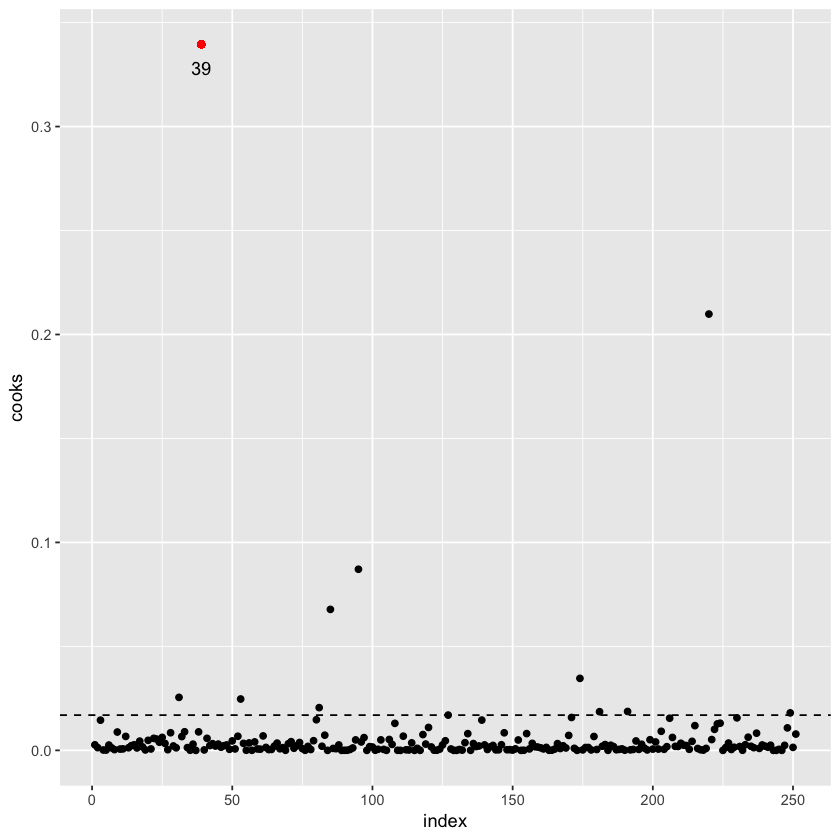

In [124]:
m2<-lm(DENSITY~.,data)
which.max(cooks.distance(m2))
d2<-data.frame(index=as.numeric(1:251),cooks=as.numeric(cooks.distance(m2)))
pic4<-ggplot(d2,aes(x=index,y=cooks))+geom_point()+annotate("text",x=39,y=0.328,label="39")+geom_point(x=39,y=0.3394935,colour="red")+geom_hline(yintercept=4/(251-15),lty=2)
print(pic4)
data[39,]#this guy is really very fat

To determine if this man's record of WEIGHT is a typo or not, we still use the BMI equation to calculat th WEIGHT by assuming other two values are correct, and we get the WEIGHT = 345.53lbs, which is very close to the record, so this guy is just very fat. From the summary of data, we can see he is so far away from the 3rd quantile, and it will iinfluence our model a lot, so we decide to delete it.

In [125]:
data<-data[-39,]#delete it becasue this man is too fat

221 
219

,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
221,1.0706,54,153.25,70.5,24.5,38.5,99,91.8,96.2,57.7,38.1,23.9,31.4,29.9,18.9


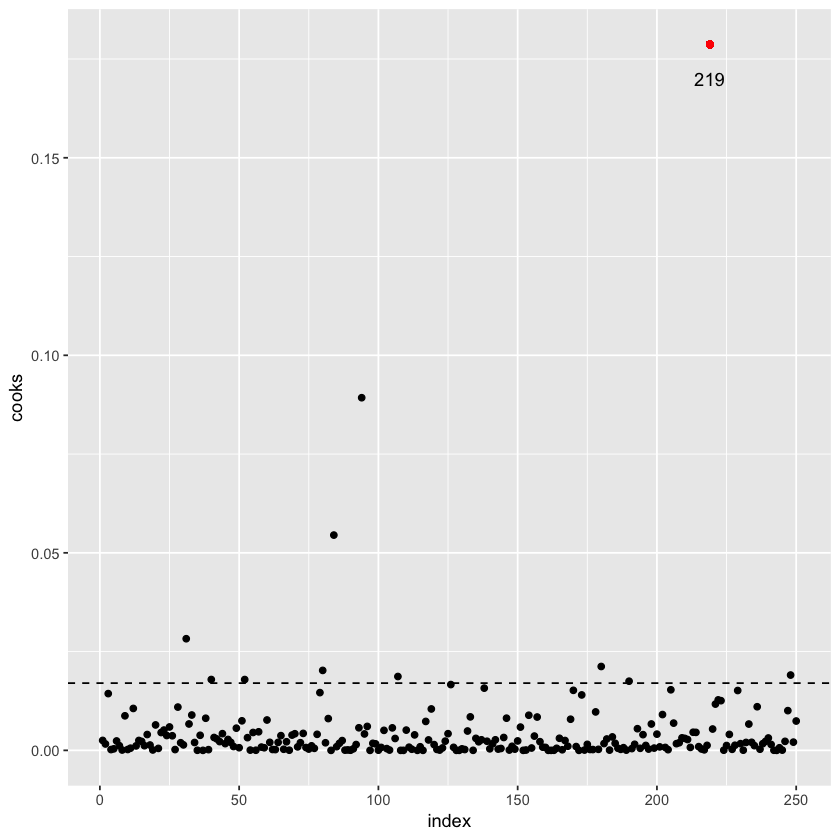

In [126]:
m3<-lm(DENSITY~.,data)
which.max(cooks.distance(m3))
d3<-data.frame(index=as.numeric(1:250),cooks=as.numeric(cooks.distance(m3)))
pic3<-ggplot(d3,aes(x=index,y=cooks))+geom_point()+annotate("text",x=219,y=0.17,label="219")+geom_point(x=219,y=0.17868883,colour="red")+geom_hline(yintercept=4/(250-15),lty=2)
print(pic3)
data[219,]#we reatin it, because his values are all in the range, not extreme value

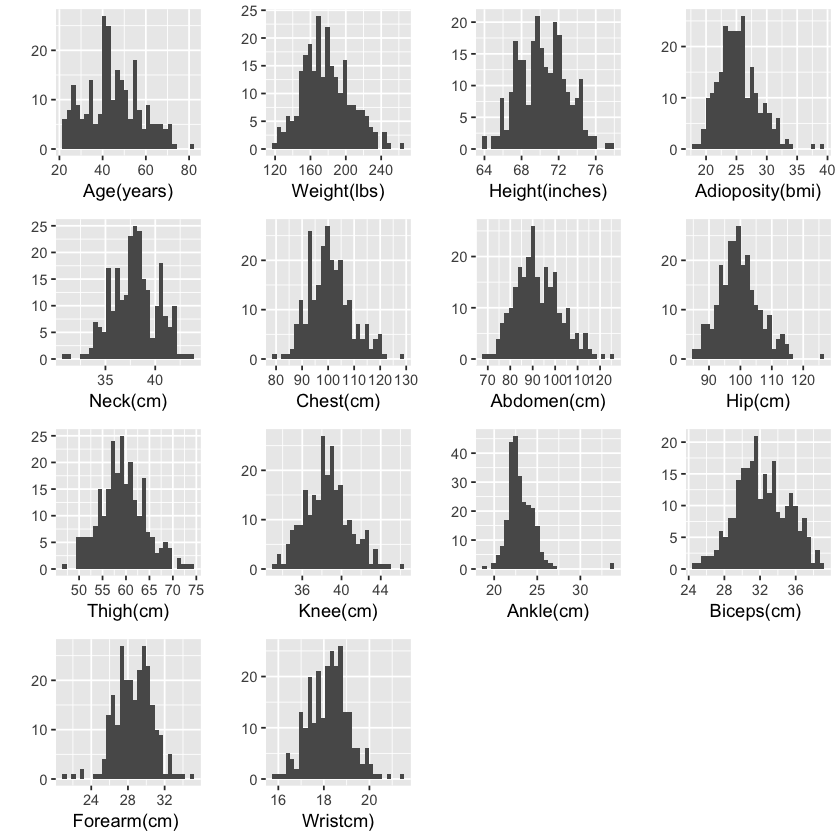

In [127]:
#Then we want to draw the distribution of each covariates which may be used in our model
p1<-qplot(data$AGE,bins = 30)+xlab("Age(years)")
p2<-qplot(data$WEIGHT,bins = 30)+xlab("Weight(lbs)")
p3<-qplot(data$HEIGHT,bins = 30)+xlab("Height(inches)")
p4<-qplot(data$ADIPOSITY,bins = 30)+xlab("Adioposity(bmi)")
p5<-qplot(data$NECK,bins = 30)+xlab("Neck(cm)")
p6<-qplot(data$CHEST,bins = 30)+xlab("Chest(cm)")
p7<-qplot(data$ABDOMEN,bins = 30)+xlab("Abdomen(cm)")
p8<-qplot(data$HIP,bins = 30)+xlab("Hip(cm)")
p9<-qplot(data$THIGH,bins = 30)+xlab("Thigh(cm)")
p10<-qplot(data$KNEE,bins = 30)+xlab("Knee(cm)")
p11<-qplot(data$ANKLE,bins = 30)+xlab("Ankle(cm)")
p12<-qplot(data$BICEPS,bins = 30)+xlab("Biceps(cm) ")
p13<-qplot(data$FOREARM,bins = 30)+xlab("Forearm(cm) ")
p14<-qplot(data$WRIST,bins = 30)+xlab("Wristcm)")
grid.arrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,ncol=4)

We notice that in the graph of age, hip and ankle, there are points very far away from other points, so we want to check who are they and if we should eliminate them.

In [128]:
which.max(data$WEIGHT)
#for age
data[which.max(data$AGE),]
which.max(data$AGE)#too old, we may delete it
#for hip
data[which.max(data$HIP),]#he is also the fatest person, but his hip is too big, and this will gain the 
#weight of hip in our model, which will make our model not robust
which.max(data$HIP)
#for ankle
data[data$ANKLE>30,]#They are not very fat, but has a fat ankle, which is abnormal
which(data$ANKLE>30)
data<-data[-c(31,40,77,84),]

[1] 40

,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
79,1.0498,81,161.25,70.25,23,37.8,96.4,95.4,99.3,53.5,37.5,21.5,31.4,26.8,18.3


[1] 77

,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
41,1.0217,45,262.75,68.75,39.1,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4


[1] 40

,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
31,1.0716,32,182,73.75,23.6,38.7,100.5,88.7,99.8,57.5,38.7,33.9,32.5,27.7,18.4
86,1.0386,67,167,67.50,26.0,36.5,98.9,89.7,96.2,54.7,37.8,33.7,32.4,27.7,18.2


[1] 31 84

In [132]:
dim(data)#after data cleaning process, w ehave 246 observations in total, and then we will divide them into 5 fold using 
#stratified sampling, and make the size of each fold as equal as possible

[1] 246  15

In [152]:
data1<-data%>%arrange(DENSITY)
data1$index=1:246
d1<-data1[which(data1$index%%5==1),]#50*16
d2<-data1[which(data1$index%%5==2),]#49*16
d3<-data1[which(data1$index%%5==3),]#49*16
d4<-data1[which(data1$index%%5==4),]#49*16
d5<-data1[which(data1$index%%5==0),]#49*16
d1<-d1[,-16]
d2<-d2[,-16]
d3<-d3[,-16]#delete index column
d4<-d4[,-16]
d5<-d5[,-16]
model_data<-rbind(d1,d2,d3,d4,d5)#combine them into one data
model_data<-model_data[,-5]
str(model_data)

'data.frame':	246 obs. of  14 variables:
 $ DENSITY: num  0.995 1.021 1.026 1.028 1.03 ...
 $ AGE    : int  51 44 50 48 66 56 67 62 49 48 ...
 $ WEIGHT : num  219 223 203 217 234 ...
 $ HEIGHT : num  64 69.8 67 70 72 ...
 $ NECK   : num  41.2 40.9 40.2 37.3 41.4 35.6 40.7 40.5 40.2 38 ...
 $ CHEST  : num  120 122 115 113 120 ...
 $ ABDOMEN: num  122 114 108 111 109 ...
 $ HIP    : num  113 107 102 114 109 ...
 $ THIGH  : num  62.5 63.5 61.3 67.7 63.7 60.9 58.2 61.8 63.7 59.3 ...
 $ KNEE   : num  36.9 40.3 41.1 40.9 42.4 38 38.8 39.8 40.3 38.1 ...
 $ ANKLE  : num  23.6 21.8 24.7 25 24.6 22.1 24.1 22.7 23.2 21.8 ...
 $ BICEPS : num  34.7 34.8 34.1 36.7 35.6 32.5 32.1 37.7 36.8 31.8 ...
 $ FOREARM: num  29.1 30.7 31 29.8 30.7 29.8 29.3 30.9 31 27.3 ...
 $ WRIST  : num  18.4 17.4 18.3 18.4 19.5 18.3 18.5 19.2 18.9 17.5 ...


In [160]:
set.seed(999)
train.control <- trainControl(method = "cv", number = 10)
back.model <- train(DENSITY ~., data = model_data,
                    method = "leapBackward", 
                    tuneGrid = data.frame(nvmax = 1:5),
                    trControl = train.control
                    )
back.model$results
summary(back.model$finalModel)#height,chest,abdomen,wrist

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.01094132,0.6632453,0.008772750,0.001796418,0.11874882,0.001038512
2,0.01061860,0.6876401,0.008731738,0.001655325,0.10778159,0.001206632
3,0.01027944,0.7070383,0.008479554,0.001626701,0.10260107,0.001189648
4,0.01026534,0.7090329,0.008481432,0.001629387,0.09836019,0.001150007
5,0.01042290,0.6998668,0.008492935,0.001670540,0.10404278,0.001160194


Subset selection object
13 Variables  (and intercept)
        Forced in Forced out
AGE         FALSE      FALSE
WEIGHT      FALSE      FALSE
HEIGHT      FALSE      FALSE
NECK        FALSE      FALSE
CHEST       FALSE      FALSE
ABDOMEN     FALSE      FALSE
HIP         FALSE      FALSE
THIGH       FALSE      FALSE
KNEE        FALSE      FALSE
ANKLE       FALSE      FALSE
BICEPS      FALSE      FALSE
FOREARM     FALSE      FALSE
WRIST       FALSE      FALSE
1 subsets of each size up to 4
Selection Algorithm: backward
         AGE WEIGHT HEIGHT NECK CHEST ABDOMEN HIP THIGH KNEE ANKLE BICEPS
1  ( 1 ) " " " "    " "    " "  " "   "*"     " " " "   " "  " "   " "   
2  ( 1 ) " " " "    " "    " "  " "   "*"     " " " "   " "  " "   " "   
3  ( 1 ) " " " "    "*"    " "  " "   "*"     " " " "   " "  " "   " "   
4  ( 1 ) " " " "    "*"    " "  "*"   "*"     " " " "   " "  " "   " "   
         FOREARM WRIST
1  ( 1 ) " "     " "  
2  ( 1 ) " "     "*"  
3  ( 1 ) " "     "*"  
4  ( 1 ) " "     

In [161]:
for.model <- train(DENSITY ~., data = model_data,
                    method = "leapForward", 
                    tuneGrid = data.frame(nvmax = 1:5),
                    trControl = train.control
                    )
for.model$results
summary(for.model$finalModel)#weight,abdomen,biceps,wrist

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.01094272,0.6640965,0.008756904,0.001589880,0.09498110,0.0008891173
2,0.01068630,0.6854932,0.008570046,0.001302081,0.07257009,0.0007687938
3,0.01020307,0.7171789,0.008355927,0.001140019,0.05853630,0.0006887203
4,0.01008265,0.7258780,0.008261488,0.001054274,0.05010757,0.0006328274
5,0.01030714,0.7143997,0.008520686,0.001075094,0.05444333,0.0007091764


Subset selection object
13 Variables  (and intercept)
        Forced in Forced out
AGE         FALSE      FALSE
WEIGHT      FALSE      FALSE
HEIGHT      FALSE      FALSE
NECK        FALSE      FALSE
CHEST       FALSE      FALSE
ABDOMEN     FALSE      FALSE
HIP         FALSE      FALSE
THIGH       FALSE      FALSE
KNEE        FALSE      FALSE
ANKLE       FALSE      FALSE
BICEPS      FALSE      FALSE
FOREARM     FALSE      FALSE
WRIST       FALSE      FALSE
1 subsets of each size up to 4
Selection Algorithm: forward
         AGE WEIGHT HEIGHT NECK CHEST ABDOMEN HIP THIGH KNEE ANKLE BICEPS
1  ( 1 ) " " " "    " "    " "  " "   "*"     " " " "   " "  " "   " "   
2  ( 1 ) " " "*"    " "    " "  " "   "*"     " " " "   " "  " "   " "   
3  ( 1 ) " " "*"    " "    " "  " "   "*"     " " " "   " "  " "   " "   
4  ( 1 ) " " "*"    " "    " "  " "   "*"     " " " "   " "  " "   "*"   
         FOREARM WRIST
1  ( 1 ) " "     " "  
2  ( 1 ) " "     " "  
3  ( 1 ) " "     "*"  
4  ( 1 ) " "     "

In [162]:
both.model <- train(DENSITY ~., data = model_data,
                    method = "leapSeq", 
                    tuneGrid = data.frame(nvmax = 1:5),
                    trControl = train.control
                    )
both.model$results
summary(both.model$finalModel)#weight,abdomen

nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
1,0.01096489,0.6720773,0.008764928,0.001688703,0.10127445,0.001145494
2,0.01027268,0.7080919,0.008180960,0.001325592,0.08732919,0.001154539
3,0.01028768,0.7100010,0.008444174,0.001080302,0.07421438,0.001007105
4,0.01063189,0.6872188,0.008681531,0.001585678,0.12220941,0.001564140
5,0.01083462,0.6755803,0.008857250,0.001813053,0.11867434,0.001246294


Subset selection object
13 Variables  (and intercept)
        Forced in Forced out
AGE         FALSE      FALSE
WEIGHT      FALSE      FALSE
HEIGHT      FALSE      FALSE
NECK        FALSE      FALSE
CHEST       FALSE      FALSE
ABDOMEN     FALSE      FALSE
HIP         FALSE      FALSE
THIGH       FALSE      FALSE
KNEE        FALSE      FALSE
ANKLE       FALSE      FALSE
BICEPS      FALSE      FALSE
FOREARM     FALSE      FALSE
WRIST       FALSE      FALSE
1 subsets of each size up to 2
Selection Algorithm: 'sequential replacement'
         AGE WEIGHT HEIGHT NECK CHEST ABDOMEN HIP THIGH KNEE ANKLE BICEPS
1  ( 1 ) " " " "    " "    " "  " "   "*"     " " " "   " "  " "   " "   
2  ( 1 ) " " "*"    " "    " "  " "   "*"     " " " "   " "  " "   " "   
         FOREARM WRIST
1  ( 1 ) " "     " "  
2  ( 1 ) " "     " "  

In [165]:
mse_back<-rep(0,5)
mse_for<-rep(0,5)
mse_both<-rep(0,5)
for(i in 1:5){
    if(i==1){
        test_data<-model_data[1:50,]
        train_data<-model_data[-(1:50),]
    }else{
        test_data<-model_data[((49*i-47):(49*i+1)),]
        train_data<-model_data[-((49*i-47):(49*i+1)),]
    }
    model_back<-lm(DENSITY~HEIGHT+CHEST+ABDOMEN+WRIST,data=train_data)
    model_for<-lm(DENSITY~WEIGHT+ABDOMEN+BICEPS+WRIST,data=train_data)
    model_both<-lm(DENSITY~WEIGHT+ABDOMEN,data=train_data)
    pre_back<-predict(model_back,newdata=test_data)
    pre_for<-predict(model_for,newdata=test_data)
    pre_both<-predict(model_both,newdata=test_data)
    mse_back[i]=sum((pre_back-test_data$DENSITY)^2)/(nrow(test_data))
    mse_for[i]=sum((pre_for-test_data$DENSITY)^2)/(nrow(test_data))
    mse_both[i]=sum((pre_both-test_data$DENSITY)^2)/(nrow(test_data))
}
mean(mse_back)
mean(mse_for)
mean(mse_both)
#so we will choose the backward model with DENSITY~HEIGHT+CHEST+ABDOMEN+WRIST

[1] 0.0001027537

[1] 0.0001063574

[1] 0.0001081477

In [166]:
final_model<-lm(DENSITY~HEIGHT+CHEST+ABDOMEN+WRIST,data=model_data)

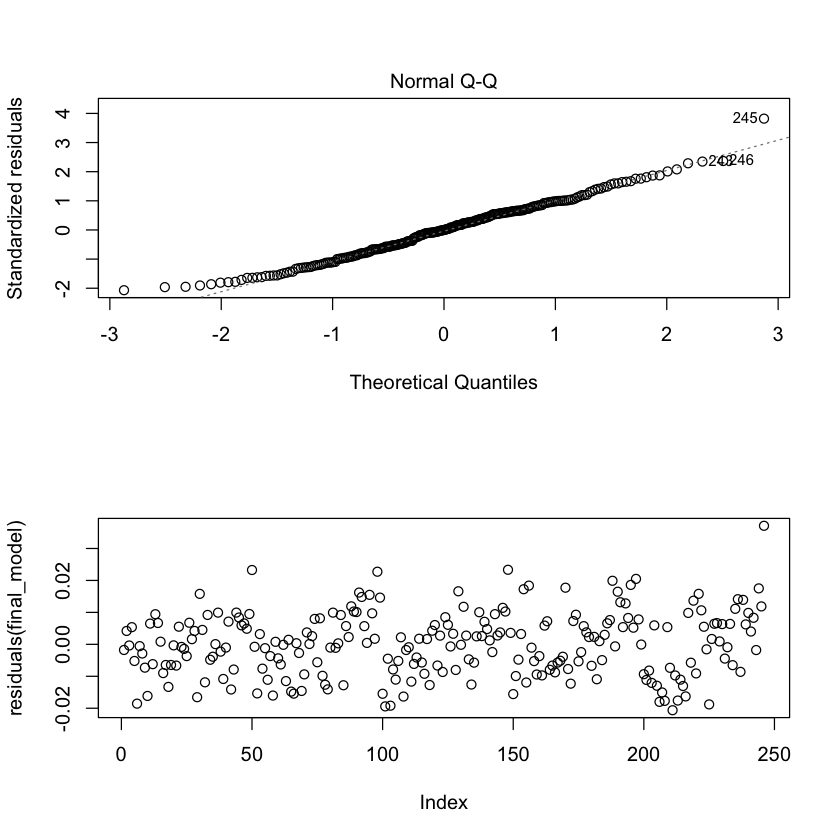

In [180]:
par(mfrow=c(2,1))
plot(final_model,which=2)
plot(residuals(final_model))
par(mfrow=c(1,1))